In [1]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

2023-05-12 08:32:01.239606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 08:32:01.239635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [3]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [4]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [5]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [6]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [7]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [8]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [9]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [10]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [11]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [12]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [32]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D


def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model



class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(2 * ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [33]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN))
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(3366, 33)
(3367, 33)
(13466, 33)
(13464, 33)
(856, 33)
(858, 33)
(3420, 33)
(3419, 33)


In [34]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4222, 33), (4225, 33), (16886, 33), (16883, 33))

In [35]:
pre_test_ST = np.vstack((pre_test_pos_ST_CNN, pre_test_neg_ST_CNN))

pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST.shape, pre_test_ST_labels.shape

((8447, 33), (8447,))

In [36]:
pre_train_ST = np.vstack((pre_train_pos_ST_CNN, pre_train_neg_ST_CNN))

pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST.shape, pre_train_ST_labels.shape

((33769, 33), (33769,))

In [37]:
pre_train_ST, pre_train_ST_labels

(array([[ 5,  3,  7, ...,  3,  9,  5],
        [14,  0, 14, ..., 14,  2,  5],
        [ 5, 10,  0, ..., 16, 13, 14],
        ...,
        [11, 18,  0, ..., 10, 10, 14],
        [18, 18, 18, ...,  6,  6,  6],
        [ 2,  0,  6, ..., 13, 19, 16]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [38]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

PRE Training CNN model...
Epoch 1/20
132/132 [==============================] - 13s 93ms/step - loss: 0.6217 - accuracy: 0.6477 - auc_roc: 0.7138 - val_loss: 0.5595 - val_accuracy: 0.7264 - val_auc_roc: 0.8029
Epoch 2/20
132/132 [==============================] - 12s 95ms/step - loss: 0.5609 - accuracy: 0.7211 - auc_roc: 0.7864 - val_loss: 0.5419 - val_accuracy: 0.7379 - val_auc_roc: 0.8145
Epoch 3/20
132/132 [==============================] - 13s 95ms/step - loss: 0.5539 - accuracy: 0.7272 - auc_roc: 0.7958 - val_loss: 0.5370 - val_accuracy: 0.7449 - val_auc_roc: 0.8198
Epoch 4/20
132/132 [==============================] - 12s 94ms/step - loss: 0.5480 - accuracy: 0.7323 - auc_roc: 0.8001 - val_loss: 0.5366 - val_accuracy: 0.7496 - val_auc_roc: 0.8231
Epoch 5/20
132/132 [==============================] - 13s 102ms/step - loss: 0.5426 - accuracy: 0.7343 - auc_roc: 0.8050 - val_loss: 0.5329 - val_accuracy: 0.7500 - val_auc_roc: 0.8262
Epoch 6/20
132/132 [==============================] -

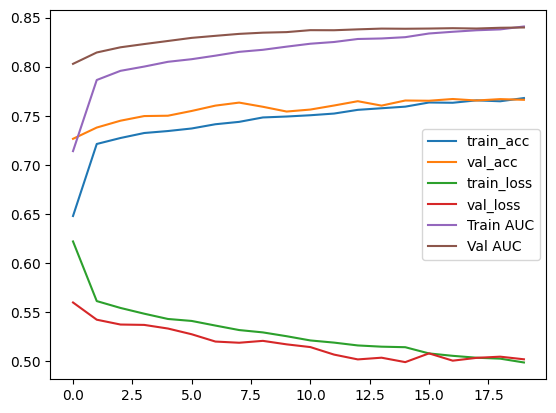


 Acc: 0.7661891795903871, MCC: 0.533605720027152, SN:0.7998578872572241, SP:0.7325443786982249, 
 CM:[[3095 1130]
 [ 845 3377]]


In [41]:
# Pretraining CNN

n_epo_cnn = 20

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_A.summary()

print("PRE Training CNN model...")

checkpointer = ModelCheckpoint(filepath="../models/pre_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

pre_history_A = model_A.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [42]:
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.4 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

PRE Training Transformer model...
Epoch 1/20
132/132 [==============================] - 43s 318ms/step - loss: 0.6241 - accuracy: 0.6528 - auc_roc: 0.7237 - val_loss: 0.5867 - val_accuracy: 0.6888 - val_auc_roc: 0.7526
Epoch 2/20
132/132 [==============================] - 45s 339ms/step - loss: 0.5934 - accuracy: 0.6843 - auc_roc: 0.7441 - val_loss: 0.5509 - val_accuracy: 0.7319 - val_auc_roc: 0.8075
Epoch 3/20
132/132 [==============================] - 48s 361ms/step - loss: 0.5514 - accuracy: 0.7229 - auc_roc: 0.7935 - val_loss: 0.5388 - val_accuracy: 0.7328 - val_auc_roc: 0.8185
Epoch 4/20
132/132 [==============================] - 46s 347ms/step - loss: 0.5397 - accuracy: 0.7340 - auc_roc: 0.8048 - val_loss: 0.5245 - val_accuracy: 0.7449 - val_auc_roc: 0.8224
Epoch 5/20
132/132 [==============================] - 44s 334ms/step - loss: 0.5310 - accuracy: 0.7402 - auc_roc: 0.8119 - val_loss: 0.5110 - val_accuracy: 0.7547 - val_auc_roc: 0.8278
Epoch 6/20
132/132 [=====================

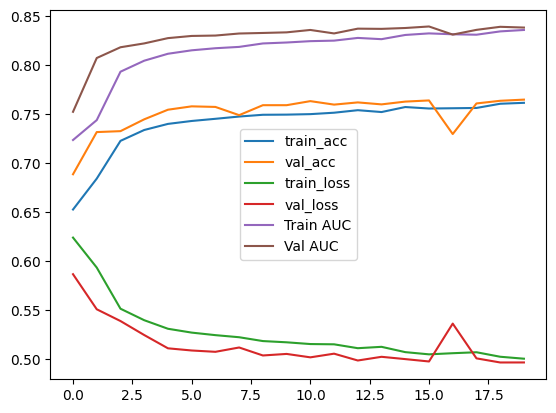


 Acc: 0.7650053273351486, MCC: 0.5302868904111047, SN:0.780909521553766, SP:0.749112426035503, 
 CM:[[3165 1060]
 [ 925 3297]]


In [44]:
# Pretraining transformer

n_epo_transformer = 20
model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

checkpointer = ModelCheckpoint(filepath="../models/pre_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("PRE Training Transformer model...")

pre_history_C = model_C.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_C.save_weights('../models/pre_model_C.h5')

y_pred = model_C.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [45]:
## Predict on real data using CNN

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

## Predict on real data using transformers

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8071748878923767, MCC: 0.6227782118420341, SN:0.8873873873873874, SP:0.7276785714285714, 
 CM:[[163  61]
 [ 25 197]]

 Acc: 0.7914798206278026, MCC: 0.5852370850957291, SN:0.8333333333333334, SP:0.75, 
 CM:[[168  56]
 [ 37 185]]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 33, 21)            5376      
                                                                 
 lambda_6 (Lambda)           (None, 33, 21, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 19, 32)        1664      
                                                                 
 dropout_36 (Dropout)        (None, 17, 19, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 9, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 2304)              0         
                                                     

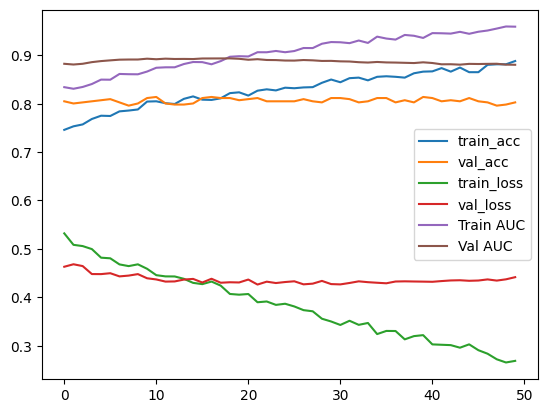


 Acc: 0.8026905829596412, MCC: 0.6053732303732303, SN:0.8018018018018018, SP:0.8035714285714286, 
 CM:[[180  44]
 [ 44 178]]


In [46]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 50

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_A.load_weights('../models/pre_model_A.h5')
#model_A.summary()

print("Training CNN model...")

#metrics = ['accuracy', tf.keras.metrics.AUC()]

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save_weights('../models/re_train_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

In [47]:
loaded_model_A = CNN_model()
loaded_model_A.load_weights("../models/re_train_model_A.h5")
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8139013452914798, MCC: 0.6326465519743427, SN:0.8738738738738738, SP:0.7544642857142857, 
 CM:[[169  55]
 [ 28 194]]


Training Embedding model...
Epoch 1/10
7/7 [==============================] - 1s 39ms/step - loss: 0.6158 - accuracy: 0.6616 - auc_roc: 0.7616 - val_loss: 0.5120 - val_accuracy: 0.7668 - val_auc_roc: 0.8293
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 0.5349 - accuracy: 0.7476 - auc_roc: 0.8106 - val_loss: 0.4887 - val_accuracy: 0.7848 - val_auc_roc: 0.8502
Epoch 3/10
7/7 [==============================] - 0s 12ms/step - loss: 0.4943 - accuracy: 0.7684 - auc_roc: 0.8427 - val_loss: 0.4727 - val_accuracy: 0.7937 - val_auc_roc: 0.8627
Epoch 4/10
7/7 [==============================] - 0s 13ms/step - loss: 0.4714 - accuracy: 0.7746 - auc_roc: 0.8591 - val_loss: 0.4557 - val_accuracy: 0.8004 - val_auc_roc: 0.8688
Epoch 5/10
7/7 [==============================] - 0s 13ms/step - loss: 0.4566 - accuracy: 0.7931 - auc_roc: 0.8677 - val_loss: 0.4538 - val_accuracy: 0.8117 - val_auc_roc: 0.8695
Epoch 6/10
7/7 [==============================] - 0s 10ms/step - loss: 0.4284

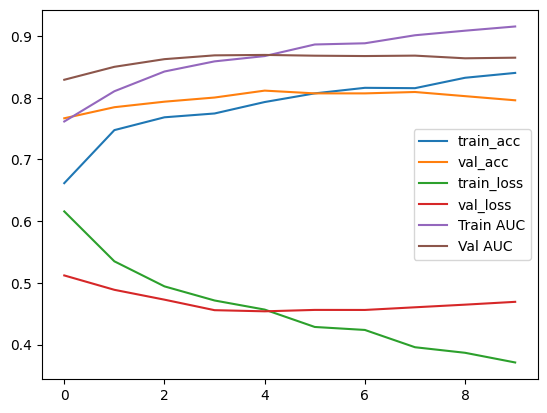


 Acc: 0.7959641255605381, MCC: 0.5922692755934444, SN:0.8108108108108109, SP:0.78125, 
 CM:[[175  49]
 [ 42 180]]


 Acc: 0.8116591928251121, MCC: 0.6238629018522536, SN:0.7882882882882883, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 47 175]]


In [49]:
########### Model B

print("Training Embedding model...")

n_epo_embed = 10
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_full_ST_embedding, test_ST_labels))

#model_B.save_weights('../models/re_train_model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/re_train_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 128)          6912      
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_5 (Transf  ((None, 33, 128),        214912    
 ormerBlock)                  (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_50 (Dropout)        (None, 128)               0  

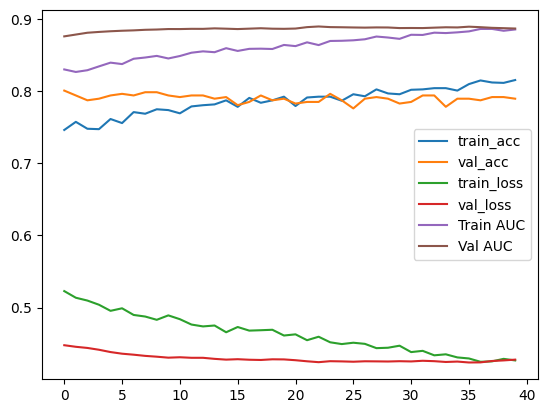


 Acc: 0.7892376681614349, MCC: 0.5809758204967063, SN:0.8333333333333334, SP:0.7455357142857143, 
 CM:[[167  57]
 [ 37 185]]


 Acc: 0.8004484304932735, MCC: 0.6014509272150713, SN:0.8198198198198198, SP:0.78125, 
 CM:[[175  49]
 [ 40 182]]


In [50]:
############# Training Transformer


model_C = transformer_model()
model_C.load_weights('../models/pre_model_C.h5')
model_C.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=metrics)

model_C.summary()

n_epo_transformer = 40

print("Training Transformer model...")

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1
                        ,callbacks=[checkpointer]
                        , validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_C.save_weights('../models/re_train_model_C.h5')

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/re_train_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [336]:
# load models from file
def load_A_models():
    model = CNN_model()
    model.load_weights('../models/re_train_model_A.h5')
    return model


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/re_train_model_B.h5')
    return model


def load_C_models():
    model = transformer_model()
    model.load_weights('../models/re_train_model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.get_layer(index = len(model.layers) - 2).output for model in members]
    #print(ensemble_outputs)
    #for item in ensemble_outputs:
    #    print(item)
    # outputs=re_stacked_model.get_layer(index=26).output
    merge = concatenate(ensemble_outputs)
    hidden = Dropout(0.4, name = 'dp_2')(merge)
    hidden = Dense(256, activation='relu', name = 'ds_1')(hidden)
    hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(32, activation='relu', name = 'ds_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    return model


# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)

n_epo_stacked = 20


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)


checkpointer = ModelCheckpoint(filepath="../models/pre_re_train_composite_model.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)


st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, verbose=1, callbacks = [checkpointer],
                               validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

# X_train_full_ST_embedding, X_test_full_ST_embedding


Loaded 3 models
Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 0.5148 - accuracy: 0.7549 - auc_roc: 0.8435 - val_loss: 0.4172 - val_accuracy: 0.8318 - val_auc_roc: 0.9006
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 0.4553 - accuracy: 0.7948 - auc_roc: 0.8696 - val_loss: 0.4207 - val_accuracy: 0.8341 - val_auc_roc: 0.8981
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 0.4351 - accuracy: 0.8061 - auc_roc: 0.8808 - val_loss: 0.4086 - val_accuracy: 0.8318 - val_auc_roc: 0.9002
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 0.4361 - accuracy: 0.7976 - auc_roc: 0.8783 - val_loss: 0.4173 - val_accuracy: 0.8318 - val_auc_roc: 0.8996
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 0.4389 - accuracy: 0.8145 - auc_roc: 0.8798 - val_loss: 0.4191 - val_accuracy: 0.8363 - val_auc_roc: 0.8977
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 0.4278

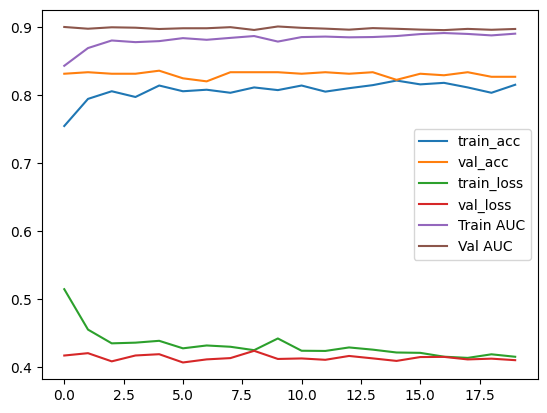


 Acc: 0.827354260089686, MCC: 0.6552977884137173, SN:0.8468468468468469, SP:0.8080357142857143, 
 CM:[[181  43]
 [ 34 188]]


 Acc: 0.8363228699551569, MCC: 0.6727754110776155, SN:0.8243243243243243, SP:0.8482142857142857, 
 CM:[[190  34]
 [ 39 183]]


In [337]:
y_pred = stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(st_history)

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

# Predict
re_stacked_model = define_stacked_model(members)
re_stacked_model.load_weights("../models/pre_re_train_composite_model.h5")
y_pred = re_stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [349]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import h5py

#re_stacked_model.summary()

#print("Number of layers: ", len(re_stacked_model.layers))

# create truncated model
#truncated_ANN_model = Model(inputs=re_stacked_model.input,
#                                 outputs=re_stacked_model.get_layer(index=21).output) #20

loaded_model_B.summary()
print("Number of layers: ", len(loaded_model_B.layers))
truncated_CNN_model = Model(inputs=loaded_model_B.input,
                                 outputs=loaded_model_B.get_layer(index=len(loaded_model_B.layers) - 2).output) #20
hidden_features = truncated_CNN_model.predict([X_test_full_ST_embedding])

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = test_ST_labels

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_56 (Dense)            (None, 256)               262400    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                16448     
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 1)                 65        
                                                                 
Total params: 278,913
Trainable params: 278,913
Non-traina

/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


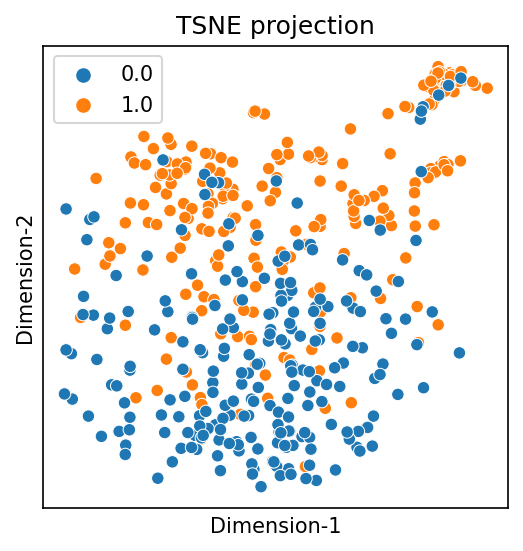

In [356]:
m = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20) #"auto"
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_stacked_no_pretraining.png"
plt.savefig(filename,dpi=150,bbox_inches='tight')
plt.show()

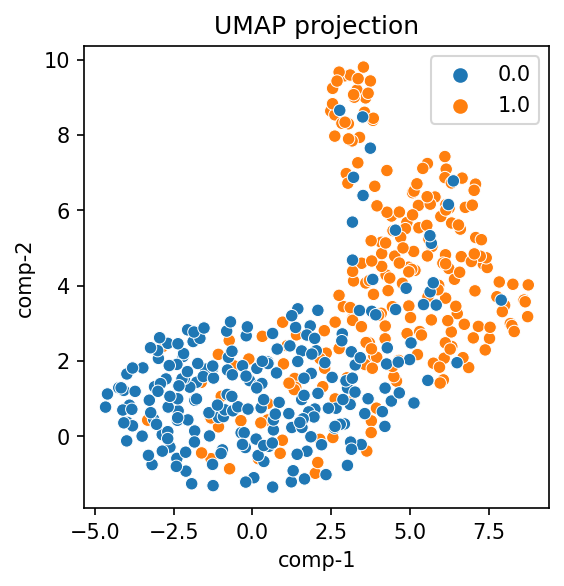

In [352]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 200

min_dist= 0.9

n_components=2

metric='euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["comp-1"] = proj_2d[:,0]
df_umap["comp-2"] = proj_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=test_ST_labels, data=df_umap).set(title="UMAP projection")
filename = "UMAP_stacked_no_pretrain.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')